Accumulating RMSE: 100%|██████████| 186075/186075 [3:14:20<00:00, 15.96it/s]   


Saved RMSE map to /home/nvme/zhaolx/Unet_train/global/regression/global_cthrmse-2017-22.npy, shape = (2000, 5143)
Saved rRMSE map to /home/nvme/zhaolx/Unet_train/global/regression/global_cthrrmse-2017-22.npy, shape = (2000, 5143)


/tmp/ipykernel_2231753/2021499925.py:88: RuntimeWarning: divide by zero encountered in divide
  rrmse_map[mask] = rmse_map[mask] / mean_truth[mask]
/tmp/ipykernel_2231753/2021499925.py:88: RuntimeWarning: invalid value encountered in divide
  rrmse_map[mask] = rmse_map[mask] / mean_truth[mask]


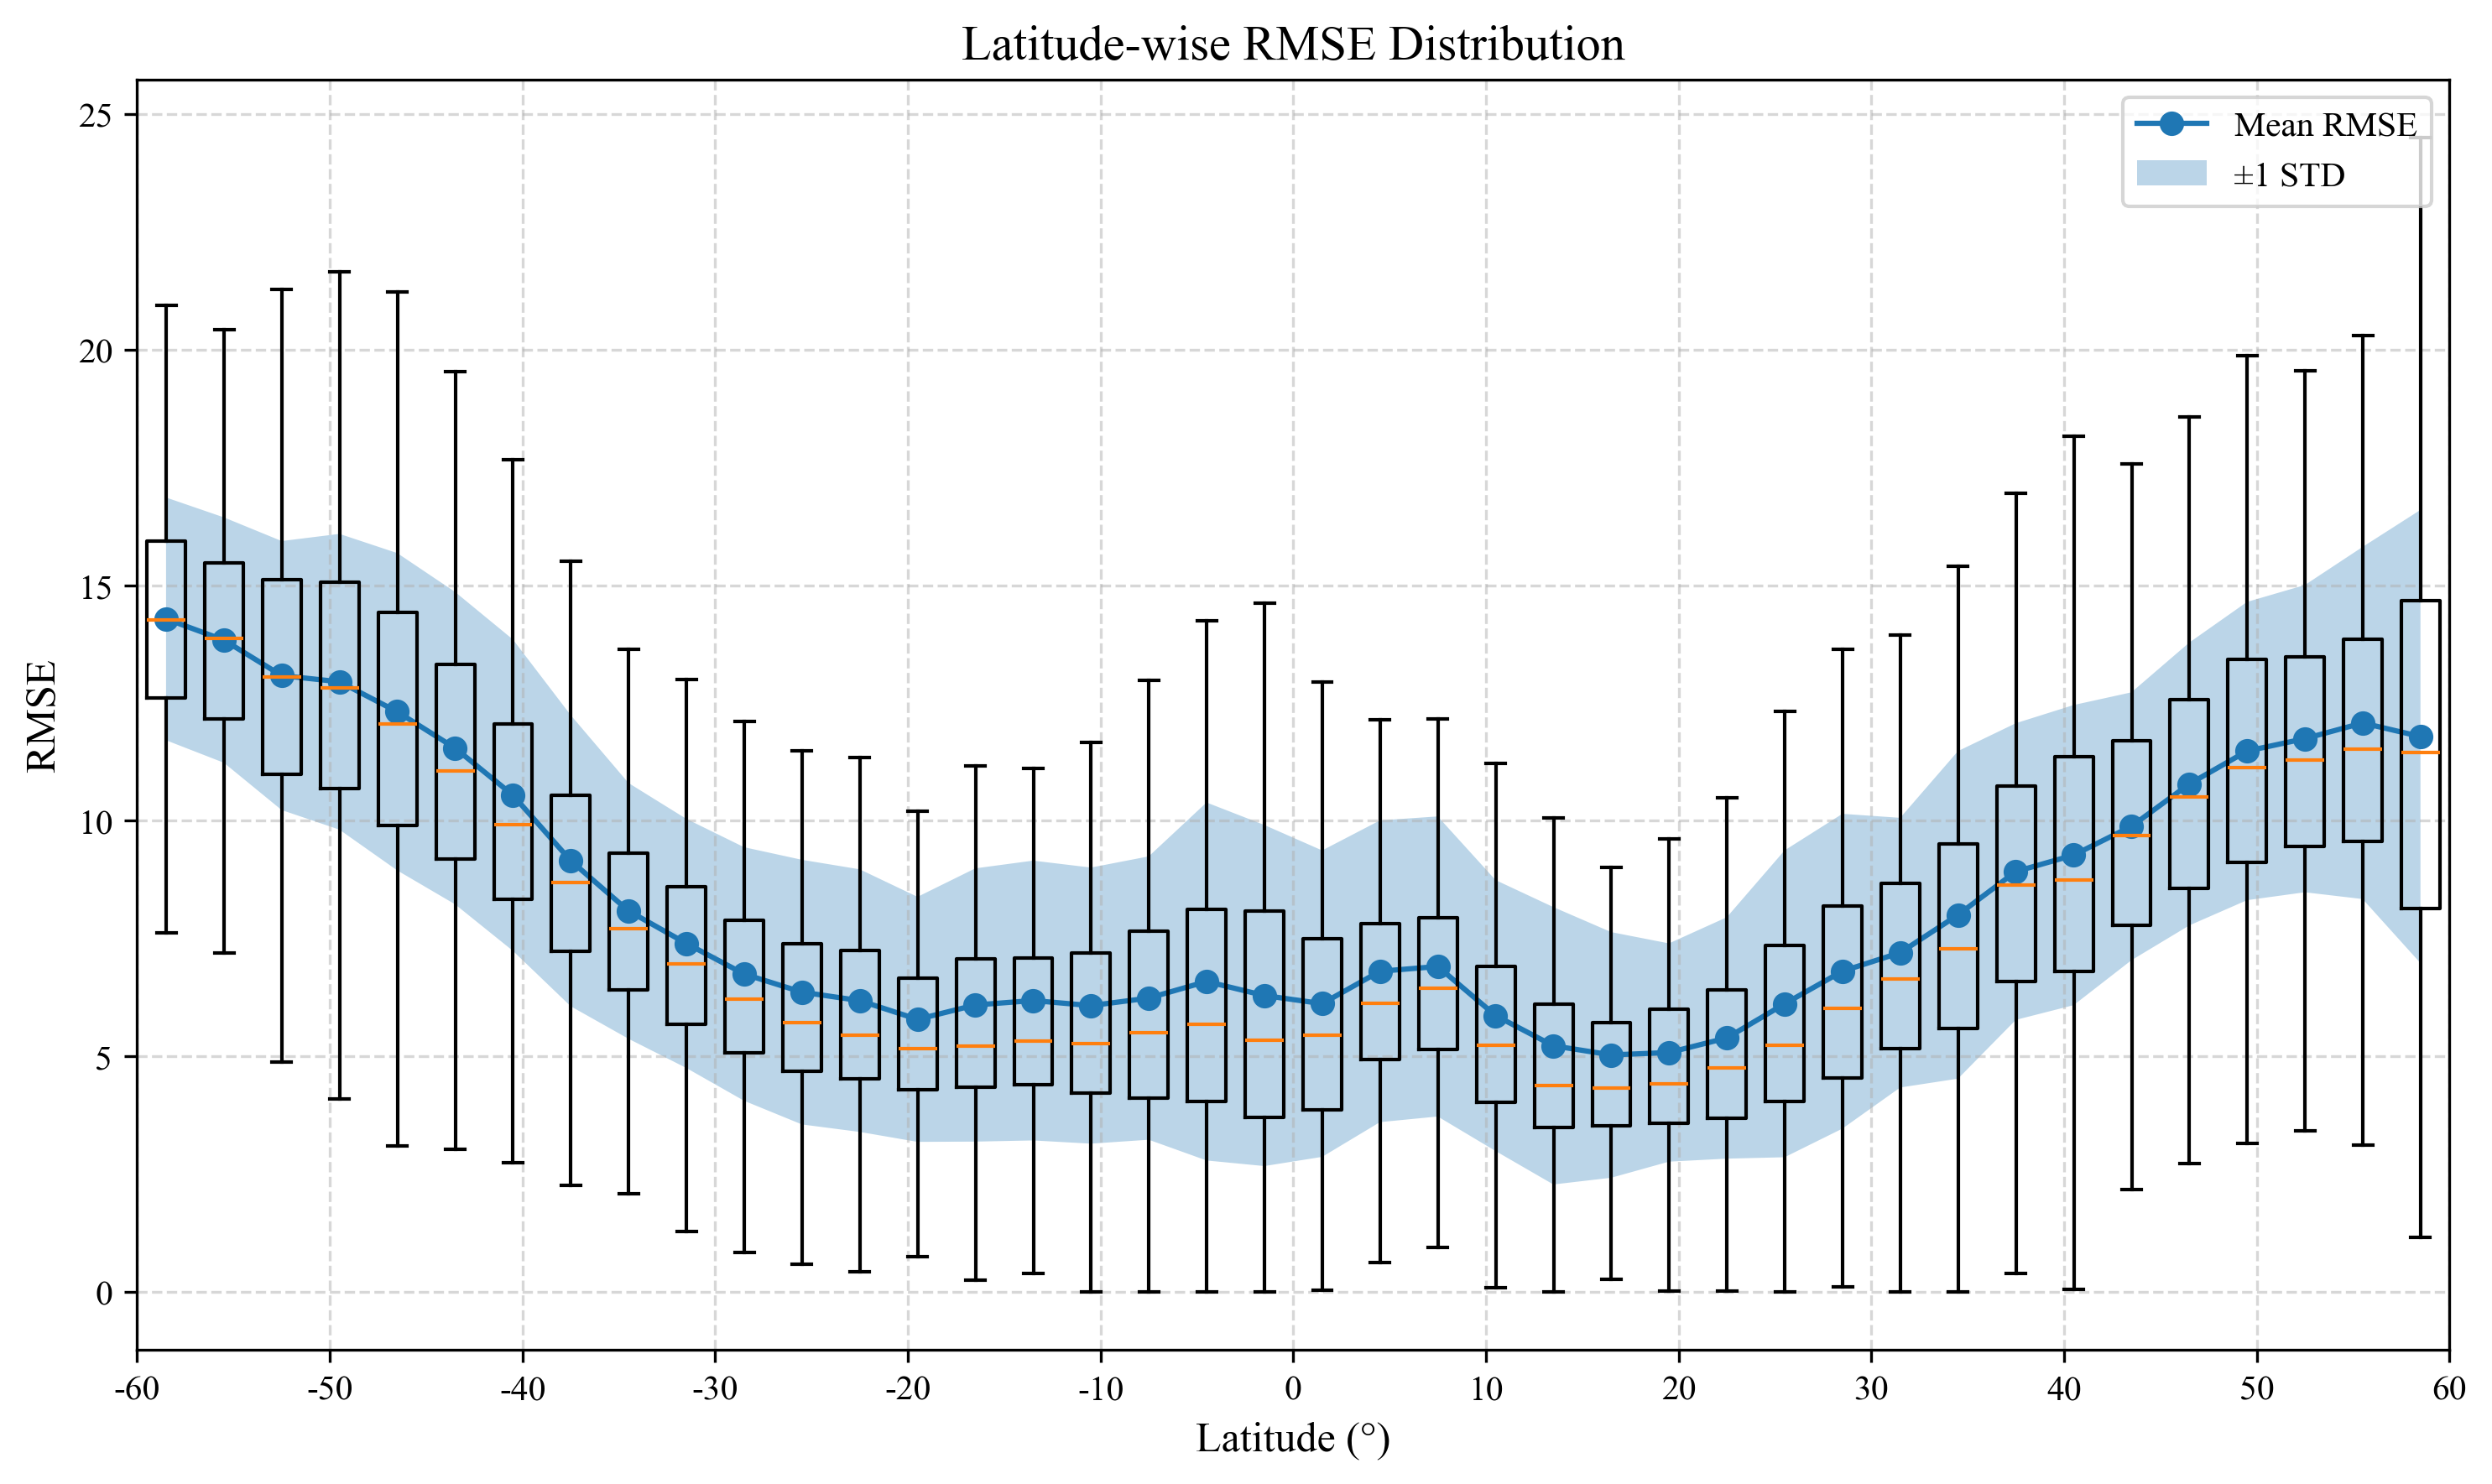

Latitude RMSE plot saved to /home/nvme/zhaolx/Unet_train/global/regression/rmse_vs_latitude.png


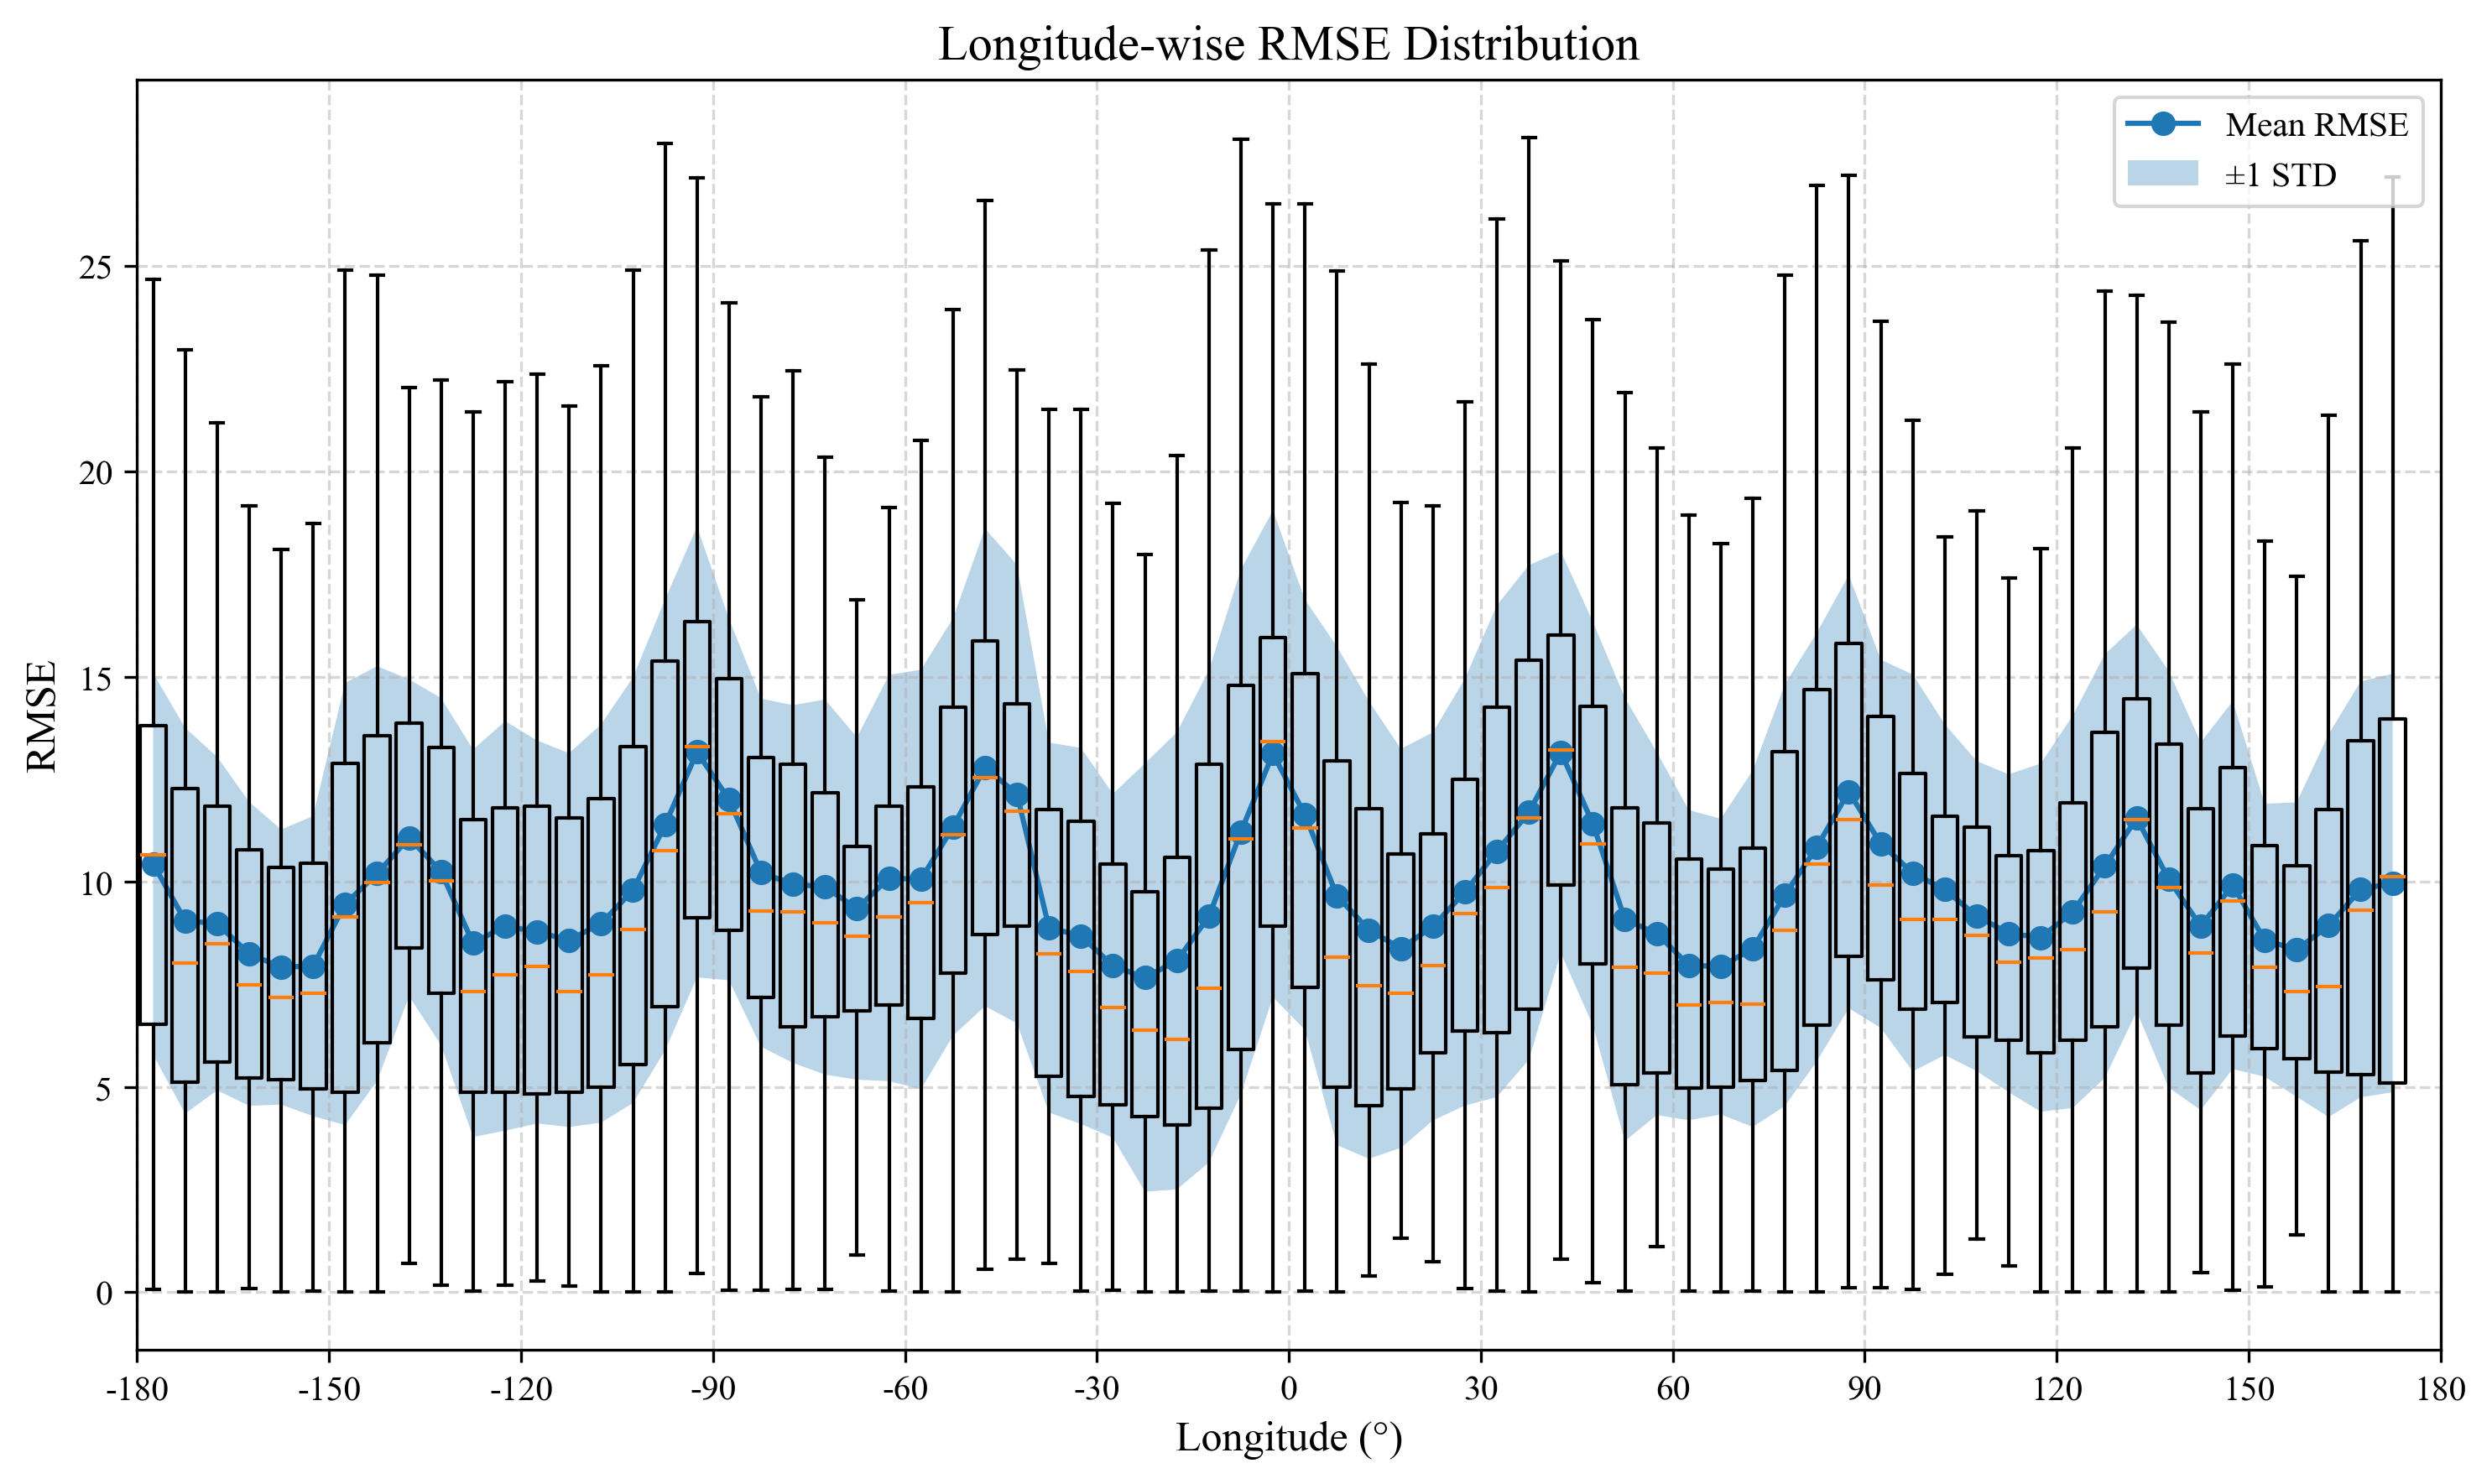

Longitude RMSE plot saved to /home/nvme/zhaolx/Unet_train/global/regression/rmse_vs_longitude.png


/home/nvme/zhaolx/.conda/envs/pyt/lib/python3.9/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


ValueError: x and y must have same first dimension, but have shapes (72,) and (40,)

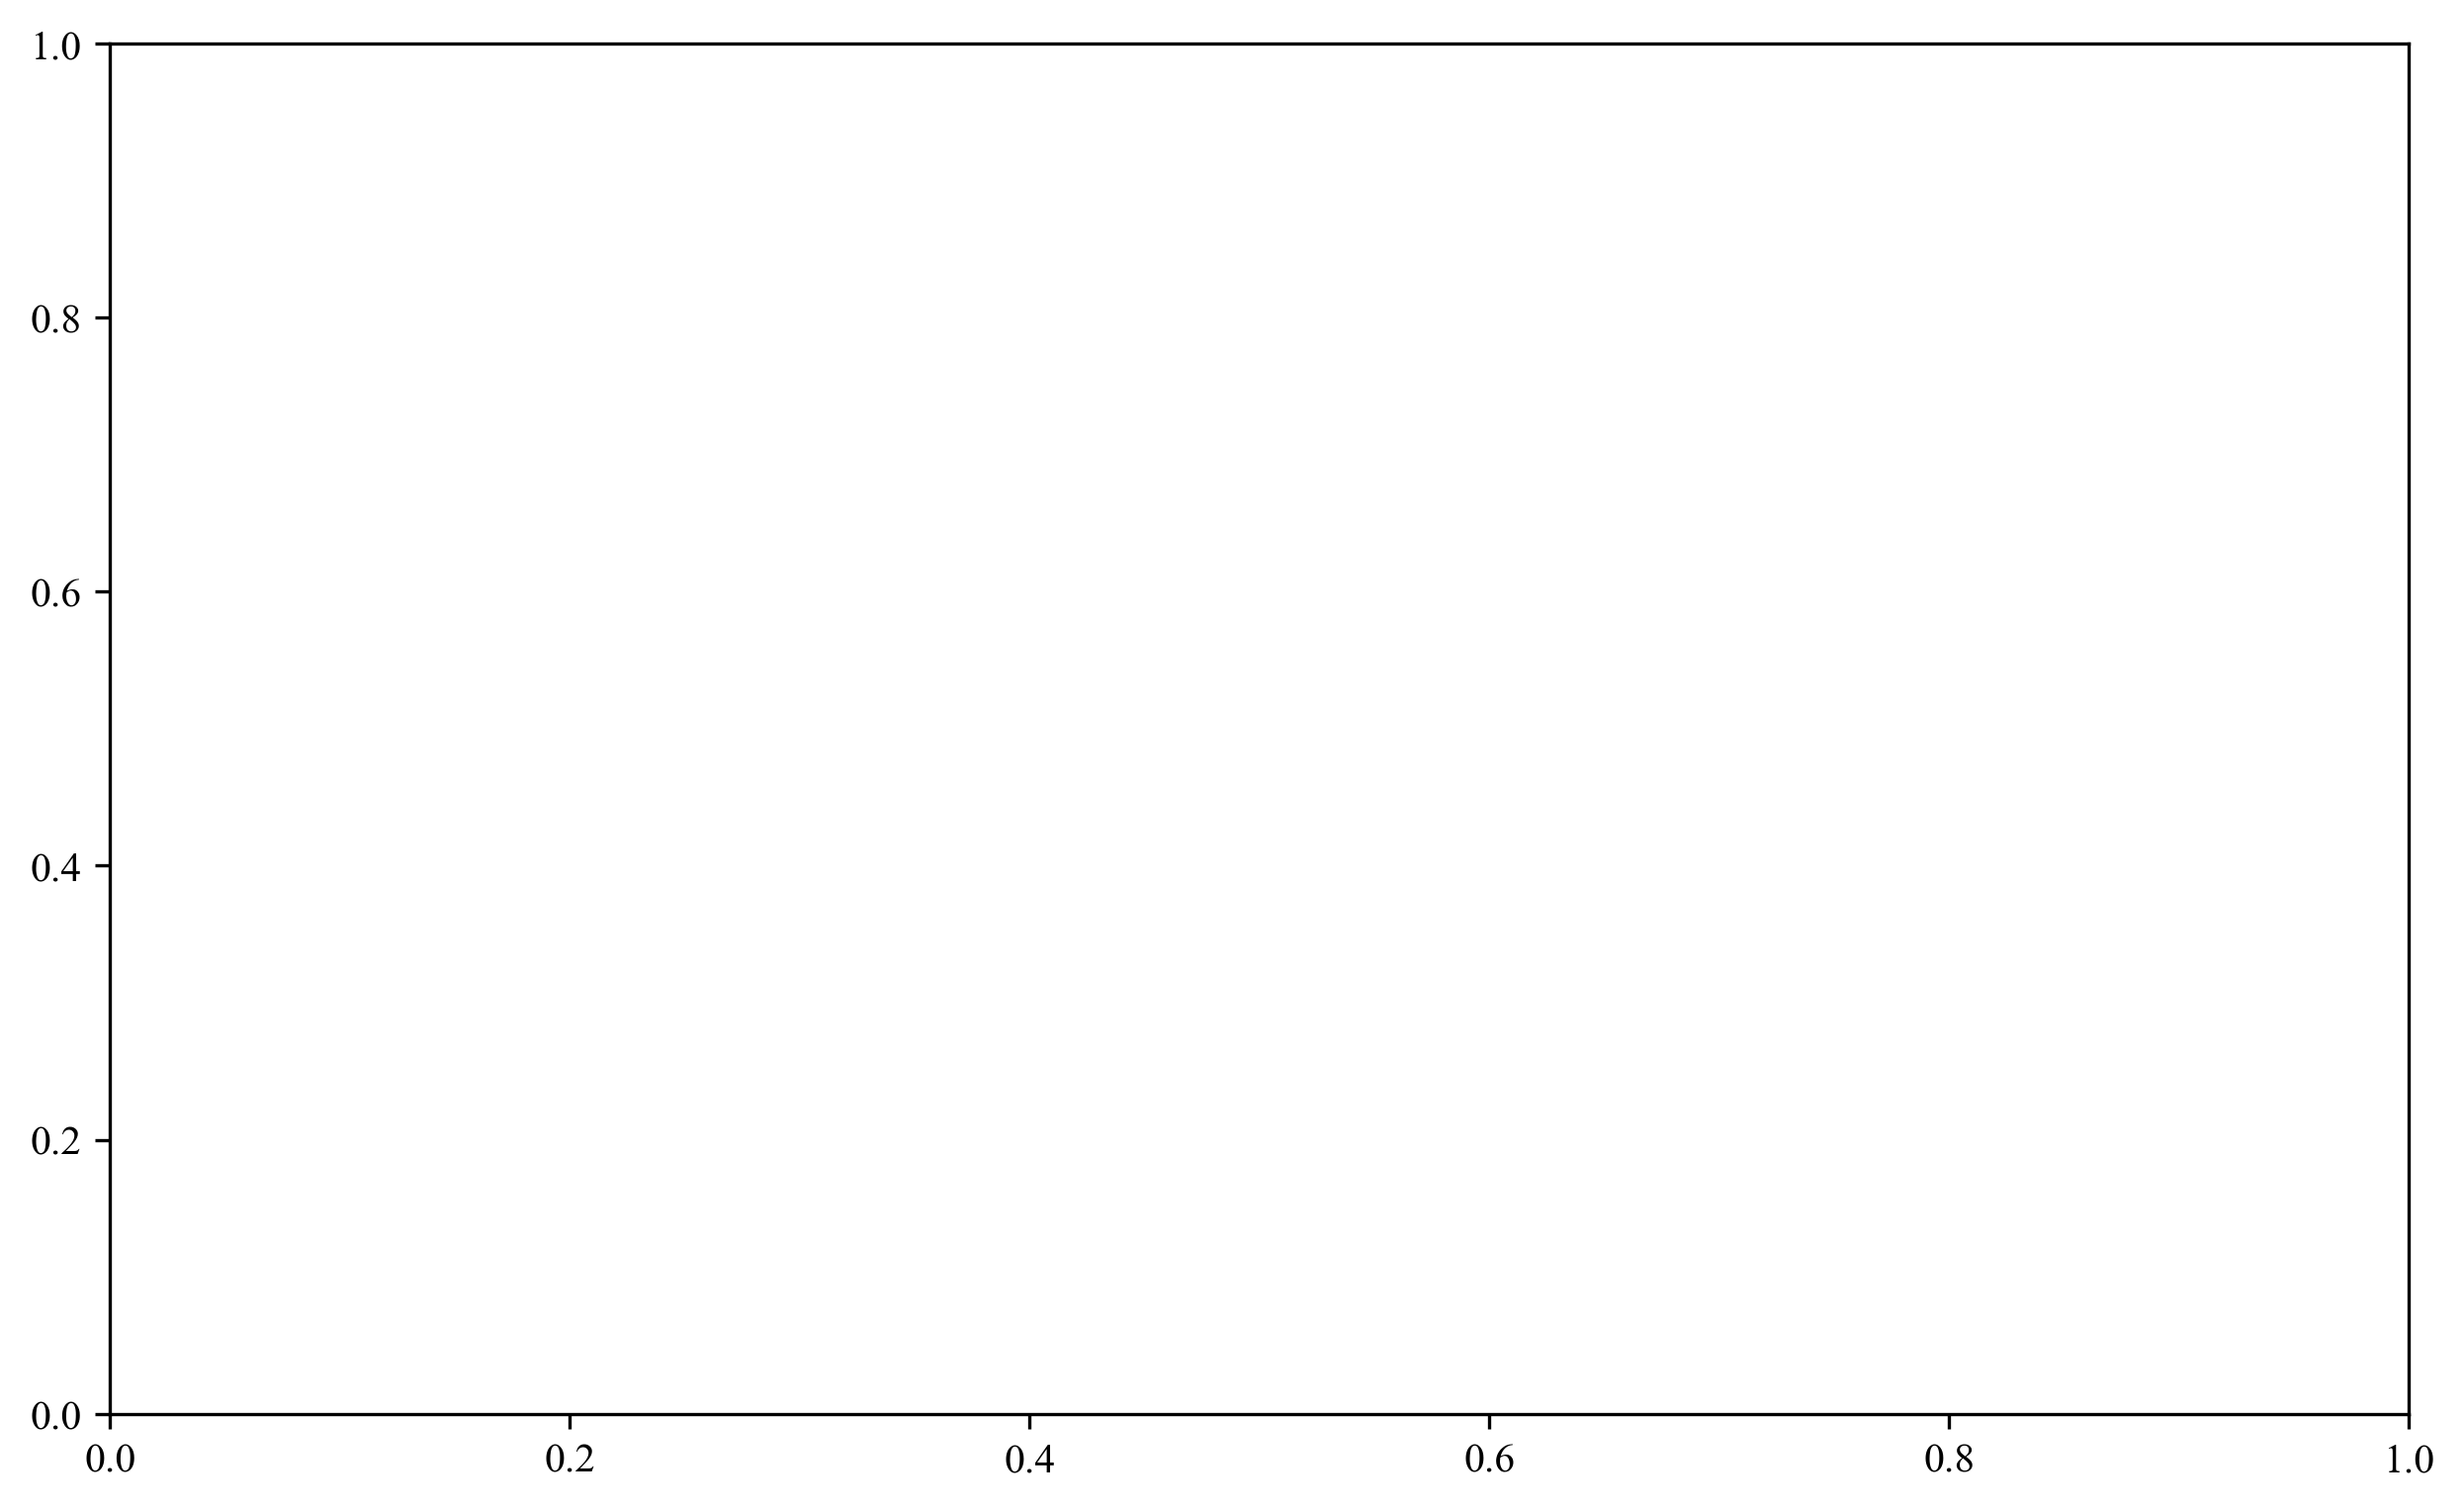

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# ——— 全局设置字体为 Times New Roman —————————————————————————————————————————
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
# ——— 参数配置 —————————————————————————————————————————————————————————————
patch_npy    = "/home/nvme/zhaolx/Unet_train/regression/savedata/300_cot_2017-22.npy"
grid_npz     = "/home/nvme/zhaolx/Dataset/grid_data.npz"
test_csv     = "/home/nvme/zhaolx/Code/SmArtUnetERA5/dataset_path/all/test_dataset_2017-22.csv"
out_rmse_npy = "/home/nvme/zhaolx/Unet_train/global/regression/global_cthrmse-2017-22.npy"
out_rrmse_npy= "/home/nvme/zhaolx/Unet_train/global/regression/global_cthrrmse-2017-22.npy"
out_lat_png  = "/home/nvme/zhaolx/Unet_train/global/regression/rmse_vs_latitude.png"
out_lon_png  = "/home/nvme/zhaolx/Unet_train/global/regression/rmse_vs_longitude.png"
out_lat_rr_png  = "/home/nvme/zhaolx/Unet_train/global/regression/rrmse_vs_latitude.png"
out_lon_rr_png  = "/home/nvme/zhaolx/Unet_train/global/regression/rrmse_vs_longitude.png"

# ——— 分块读取 patches，避免一次性载入所有 ———————————————————————————————————————
patches = np.load(patch_npy, mmap_mode='r')
N, C, H, W = patches.shape
assert (C, H, W) == (2, 64, 64), "Expect patches.shape = (N,2,64,64)"

# ——— 加载全局经纬度网格 —————————————————————————————————————————————————————
g = np.load(grid_npz)
lat_grid = g["lat_grid"]   # (2000, 5143)
lon_grid = g["lon_grid"]   # (2000, 5143)
R, S = lat_grid.shape

# ——— 读入测试样本路径列表 ————————————————————————————————————————————————————
paths = pd.read_csv(test_csv)["path"].tolist()
assert len(paths) == N, "测试集路径数需与 patches 数一致"

# ——— 初始化累加器：样本计数 & 误差平方和 & truth 总和 —————————————————————————————
count      = np.zeros((R, S), dtype=np.uint32)
sum_sq     = np.zeros((R, S), dtype=np.float64)
sum_truth  = np.zeros((R, S), dtype=np.float64)

# ——— 预提取 1D 网格向量 —————————————————————————————————————————————————————
lat_vec = lat_grid[:, 0]    # (2000,)
lon_vec = lon_grid[0, :]    # (5143,)

# ——— 流式遍历每一个 patch，累加每格点误差平方和 & truth —————————————————————————
for i, fp in enumerate(tqdm(paths, desc="Accumulating RMSE")):
    ds = np.load(fp)
    lat_patch = ds["modis"][5]    # (64,64)
    lon_patch = ds["modis"][6]    # (64,64)

    # 找到全局行/列索引
    rows = np.abs(lat_patch[:,:,None] - lat_vec[None,None,:]).argmin(axis=2)
    cols = np.abs(lon_patch[:,:,None] - lon_vec[None,None,:]).argmin(axis=2)

    pred  = patches[i, 0]          # (64,64)
    truth = patches[i, 1]          # (64,64)

    # 只保留 0–100 范围内的有效点
    valid = (pred>=0)&(pred<=100)&(truth>=0)&(truth<=100)
    if not valid.any():
        continue

    r_idx = rows[valid]
    c_idx = cols[valid]
    err   = (pred[valid] - truth[valid]).astype(np.float64)

    # 累加样本数 & 误差平方和 & truth 总和
    np.add.at(count,     (r_idx, c_idx), 1)
    np.add.at(sum_sq,    (r_idx, c_idx), err**2)
    np.add.at(sum_truth, (r_idx, c_idx), truth[valid].astype(np.float64))

# ——— 计算每个格点的 RMSE map —————————————————————————————————————————————————
rmse_map = np.full((R, S), np.nan, dtype=np.float32)
mask     = count > 0
rmse_map[mask] = np.sqrt(sum_sq[mask] / count[mask])

# ——— 保存 RMSE map —————————————————————————————————————————————————————————
np.save(out_rmse_npy, rmse_map)
print(f"Saved RMSE map to {out_rmse_npy}, shape = {rmse_map.shape}")

# ——— 计算每个格点的 rRMSE map（带除零保护） —————————————————————————————————————————
mean_truth = np.full((R, S), np.nan, dtype=np.float32)
mean_truth[mask] = sum_truth[mask] / count[mask]

# 只有 mean_truth > 0 的格点才计算 rRMSE
valid_rr = mask & (mean_truth > 0)
rrmse_map = np.full((R, S), np.nan, dtype=np.float32)
rrmse_map[valid_rr] = rmse_map[valid_rr] / mean_truth[valid_rr]

# 保存
np.save(out_rrmse_npy, rrmse_map)
print(f"Saved rRMSE map to {out_rrmse_npy}")

# ——— 按纬度 5° 分箱绘制 RMSE —————————————————————————————————————————————————————
bin_edges   = np.arange(-60,  61, 3)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
lat_bins    = np.digitize(lat_vec, bin_edges) - 1
n_bins      = len(bin_centers)

means_lat = np.full(n_bins, np.nan, dtype=np.float64)
stds_lat  = np.full(n_bins, np.nan, dtype=np.float64)
bin_vals_lat = [[] for _ in range(n_bins)]

for i in range(R):
    b = lat_bins[i]
    if 0 <= b < n_bins:
        row = rmse_map[i, :]
        vals = row[(~np.isnan(row)) & (row != 0)]
        if vals.size:
            bin_vals_lat[b].append(vals)

for b in range(n_bins):
    if bin_vals_lat[b]:
        allv = np.concatenate(bin_vals_lat[b])
        means_lat[b] = allv.mean()
        stds_lat[b]  = allv.std()

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(bin_centers, means_lat, lw=1.5, marker='o', label='Mean RMSE')
plt.fill_between(bin_centers,
                 means_lat - stds_lat,
                 means_lat + stds_lat,
                 alpha=0.3,
                 label='±1 STD')
pos_lat = bin_centers + 0.01
box_data_lat = [np.concatenate(bin_vals_lat[b]) if bin_vals_lat[b] else np.array([np.nan])
                for b in range(n_bins)]
plt.boxplot(box_data_lat,
            positions=pos_lat,
            widths=2.0,
            manage_ticks=False,
            showfliers=False)
plt.xlabel("Latitude (°)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("Latitude-wise RMSE Distribution", fontsize=14)
plt.xlim(-60, 60)
plt.xticks(np.arange(-60, 61, 10))
plt.grid(linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig(out_lat_png, dpi=300)
plt.show()
print(f"Latitude RMSE plot saved to {out_lat_png}")

# ——— 按经度 5° 分箱绘制 RMSE —————————————————————————————————————————————————————
bin_edges   = np.arange(-180, 181, 5)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
lon_bins    = np.digitize(lon_vec, bin_edges) - 1
n_bins_lon  = len(bin_centers)

means_lon = np.full(n_bins_lon, np.nan, dtype=np.float64)
stds_lon  = np.full(n_bins_lon, np.nan, dtype=np.float64)
bin_vals_lon = [[] for _ in range(n_bins_lon)]

for j in range(S):
    b = lon_bins[j]
    if 0 <= b < n_bins_lon:
        col = rmse_map[:, j]
        vals = col[(~np.isnan(col)) & (col != 0)]
        if vals.size:
            bin_vals_lon[b].append(vals)

for b in range(n_bins_lon):
    if bin_vals_lon[b]:
        allv = np.concatenate(bin_vals_lon[b])
        means_lon[b] = allv.mean()
        stds_lon[b]  = allv.std()

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(bin_centers, means_lon, lw=1.5, marker='o', label='Mean RMSE')
plt.fill_between(bin_centers,
                 means_lon - stds_lon,
                 means_lon + stds_lon,
                 alpha=0.3,
                 label='±1 STD')
pos_lon = bin_centers + 0.01
box_data_lon = [np.concatenate(bin_vals_lon[b]) if bin_vals_lon[b] else np.array([np.nan])
                for b in range(n_bins_lon)]
plt.boxplot(box_data_lon,
            positions=pos_lon,
            widths=4.0,
            manage_ticks=False,
            showfliers=False)
plt.xlabel("Longitude (°)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("Longitude-wise RMSE Distribution", fontsize=14)
plt.xlim(-180, 180)
plt.xticks(np.arange(-180, 181, 30))
plt.grid(linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig(out_lon_png, dpi=300)
plt.show()
print(f"Longitude RMSE plot saved to {out_lon_png}")


# ——— 按纬度 5° 分箱绘制 rRMSE ————————————————————————————————————————————————————
bin_edges_lat   = np.arange(-60,  61, 3)
bin_centers_lat = (bin_edges_lat[:-1] + bin_edges_lat[1:]) / 2
lat_bins        = np.digitize(lat_vec, bin_edges_lat) - 1
n_bins_lat      = len(bin_centers_lat)

means_rr = np.full(n_bins_lat, np.nan, dtype=np.float64)
stds_rr  = np.full(n_bins_lat, np.nan, dtype=np.float64)

for i in range(R):
    b = lat_bins[i]
    if 0 <= b < n_bins_lat:
        row = rrmse_map[i, :]
        # 这里同时过滤 nan、零和非有限值
        vals = row[(~np.isnan(row)) & (row != 0) & np.isfinite(row)]
        if vals.size:
            means_rr[b] = np.nanmean(vals)
            stds_rr[b]  = np.nanstd(vals)

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(bin_centers_lat, means_rr, lw=1.5, marker='o', label='Mean rRMSE')
plt.fill_between(bin_centers_lat,
                 means_rr - stds_rr,
                 means_rr + stds_rr,
                 alpha=0.3, label='±1 STD')
plt.xlabel("Latitude (°)", fontsize=12)
plt.ylabel("rRMSE", fontsize=12)
plt.title("Latitude-wise rRMSE Distribution", fontsize=14)
plt.xlim(-60, 60)
plt.xticks(np.arange(-60, 61, 10))
plt.grid(linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig(out_lat_rr_png, dpi=300)
plt.show()
print(f"Latitude rRMSE plot saved to {out_lat_rr_png}")

# ——— 按经度 5° 分箱绘制 rRMSE ————————————————————————————————————————————————————
bin_edges_lon   = np.arange(-180, 181, 5)
bin_centers_lon = (bin_edges_lon[:-1] + bin_edges_lon[1:]) / 2
lon_bins        = np.digitize(lon_vec, bin_edges_lon) - 1
n_bins_lon      = len(bin_centers_lon)

means_rr_lon = np.full(n_bins_lon, np.nan, dtype=np.float64)
stds_rr_lon  = np.full(n_bins_lon, np.nan, dtype=np.float64)

for j in range(S):
    b = lon_bins[j]
    if 0 <= b < n_bins_lon:
        col = rrmse_map[:, j]
        vals = col[(~np.isnan(col)) & (col != 0) & np.isfinite(col)]
        if vals.size:
            means_rr_lon[b] = np.nanmean(vals)
            stds_rr_lon[b]  = np.nanstd(vals)

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(bin_centers_lon, means_rr_lon, lw=1.5, marker='o', label='Mean rRMSE')
plt.fill_between(bin_centers_lon,
                 means_rr_lon - stds_rr_lon,
                 means_rr_lon + stds_rr_lon,
                 alpha=0.3, label='±1 STD')
plt.xlabel("Longitude (°)", fontsize=12)
plt.ylabel("rRMSE", fontsize=12)
plt.title("Longitude-wise rRMSE Distribution", fontsize=14)
plt.xlim(-180, 180)
plt.xticks(np.arange(-180, 181, 30))
plt.grid(linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig(out_lon_rr_png, dpi=300)
plt.show()
print(f"Longitude rRMSE plot saved to {out_lon_rr_png}")

Saved rRMSE map to /home/nvme/zhaolx/Unet_train/global/regression/global_cthrrmse-2017-22.npy


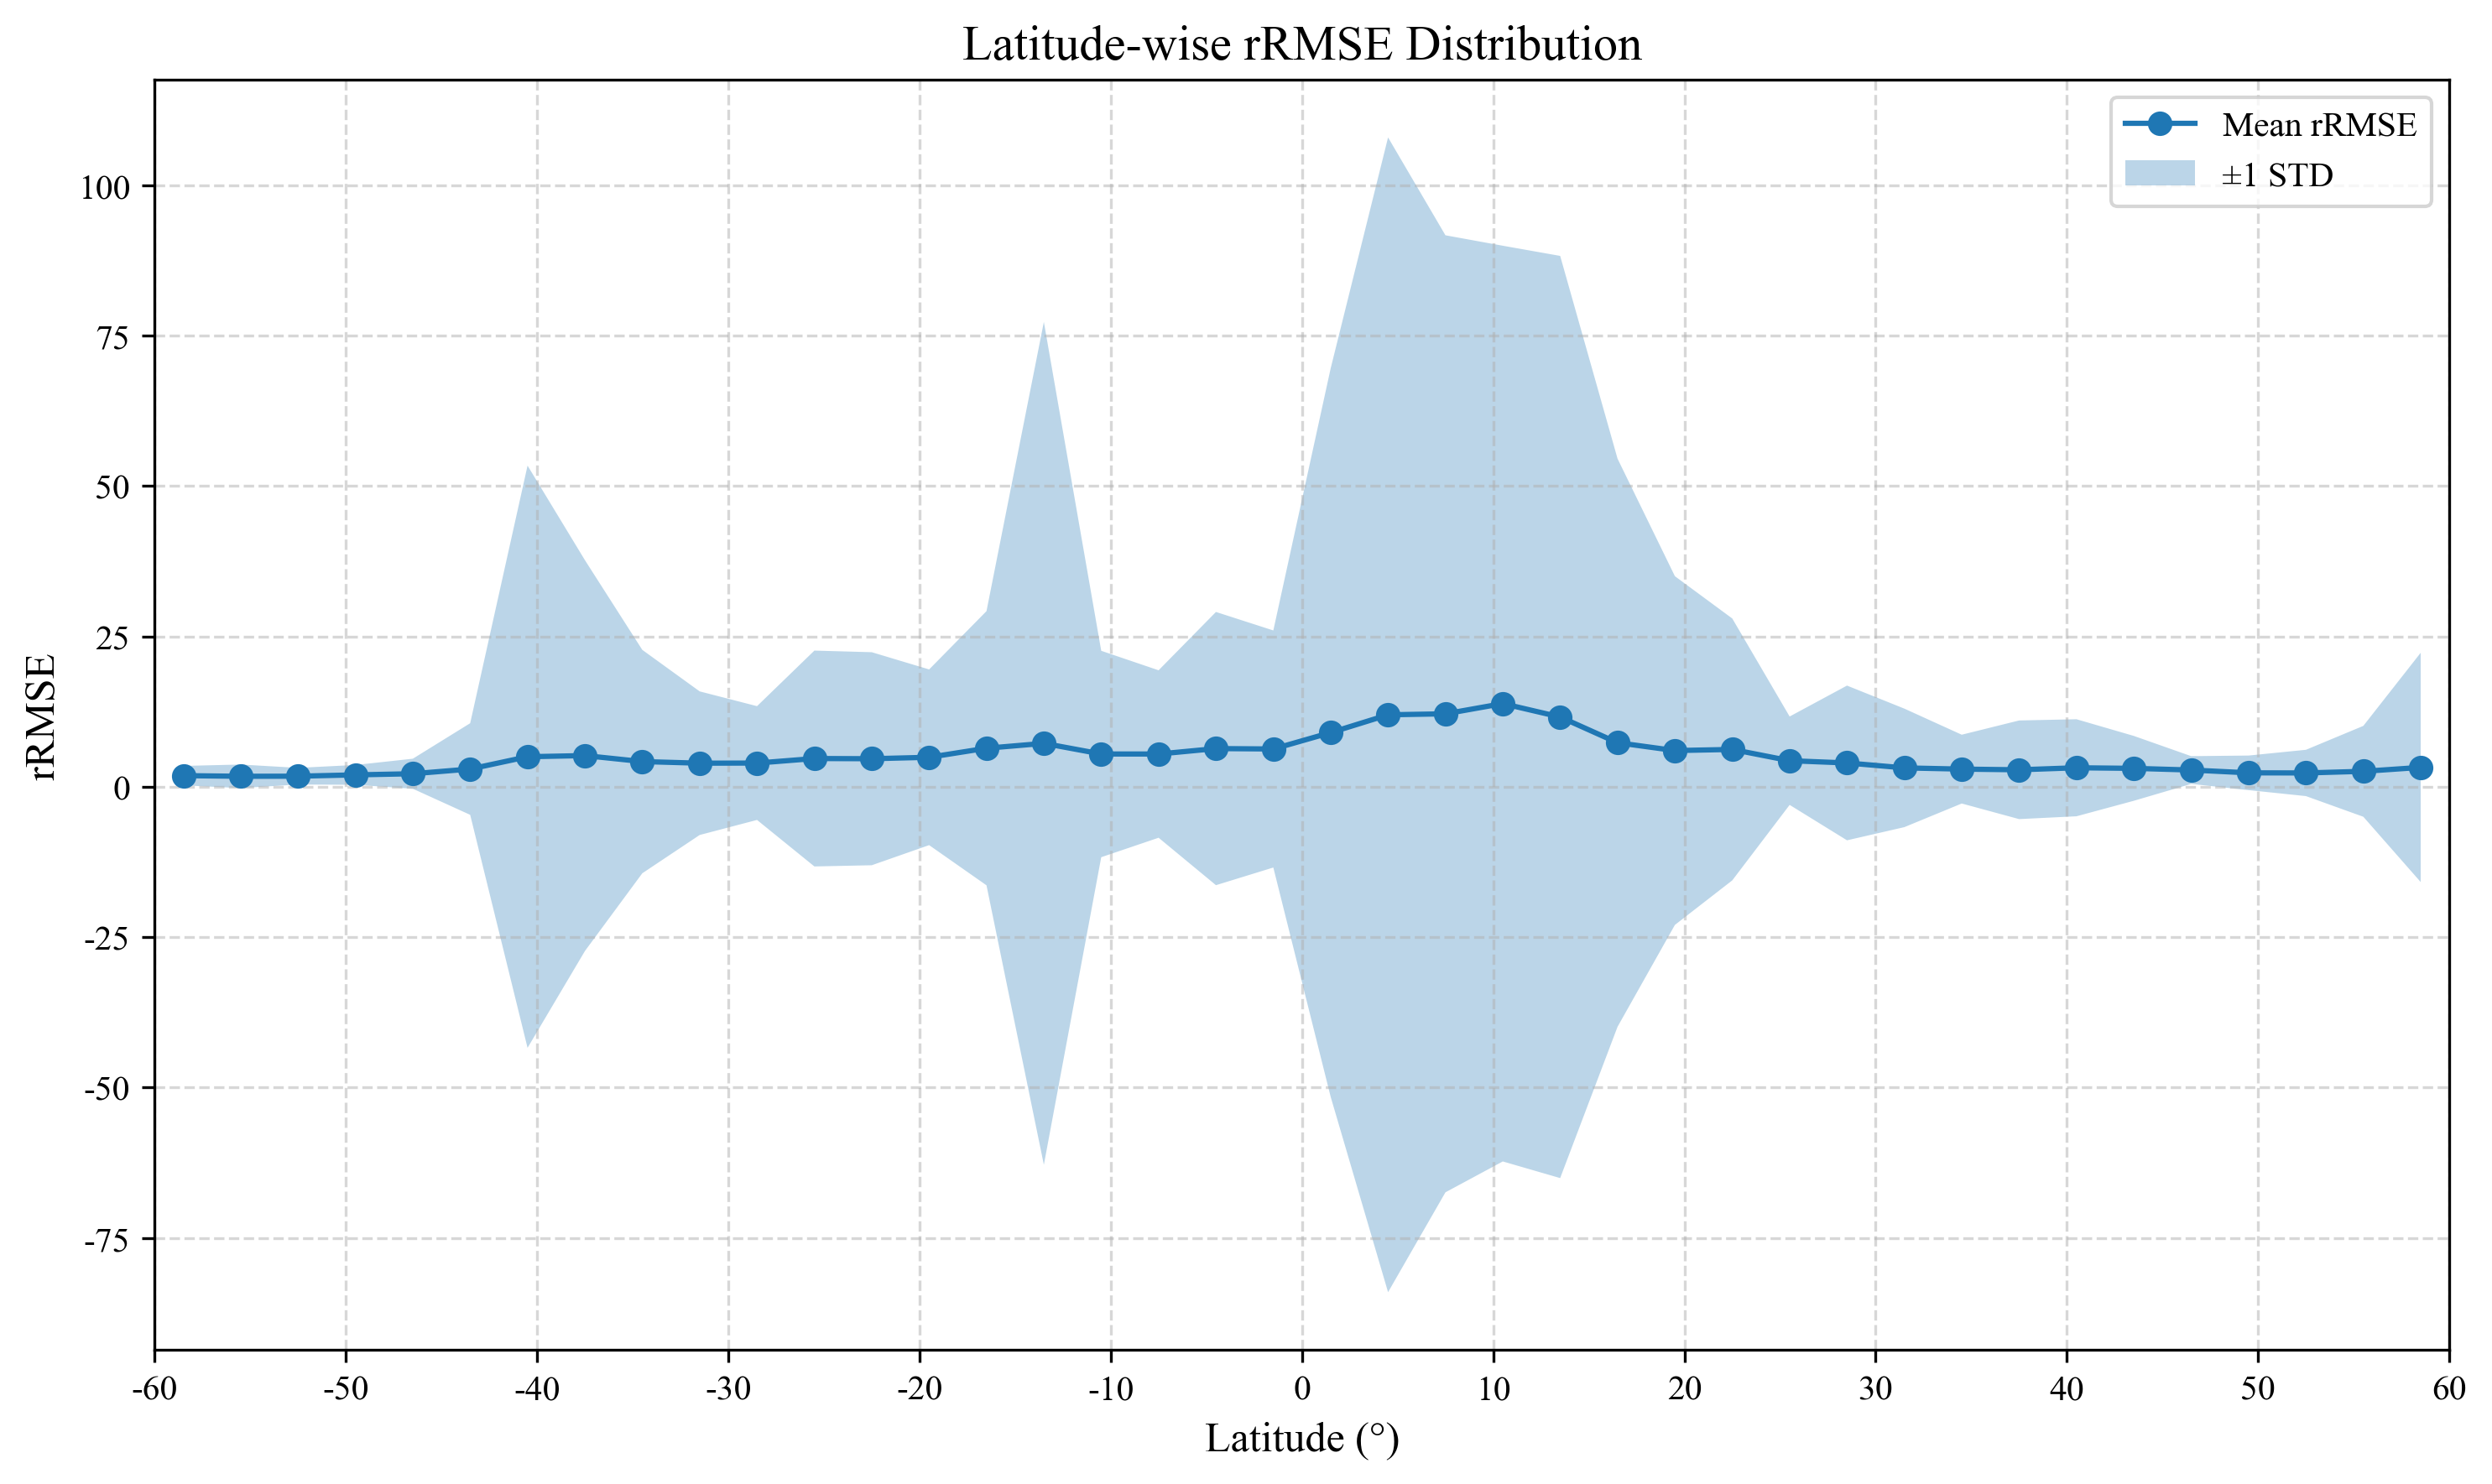

Latitude rRMSE plot saved to /home/nvme/zhaolx/Unet_train/global/regression/rrmse_vs_latitude.png


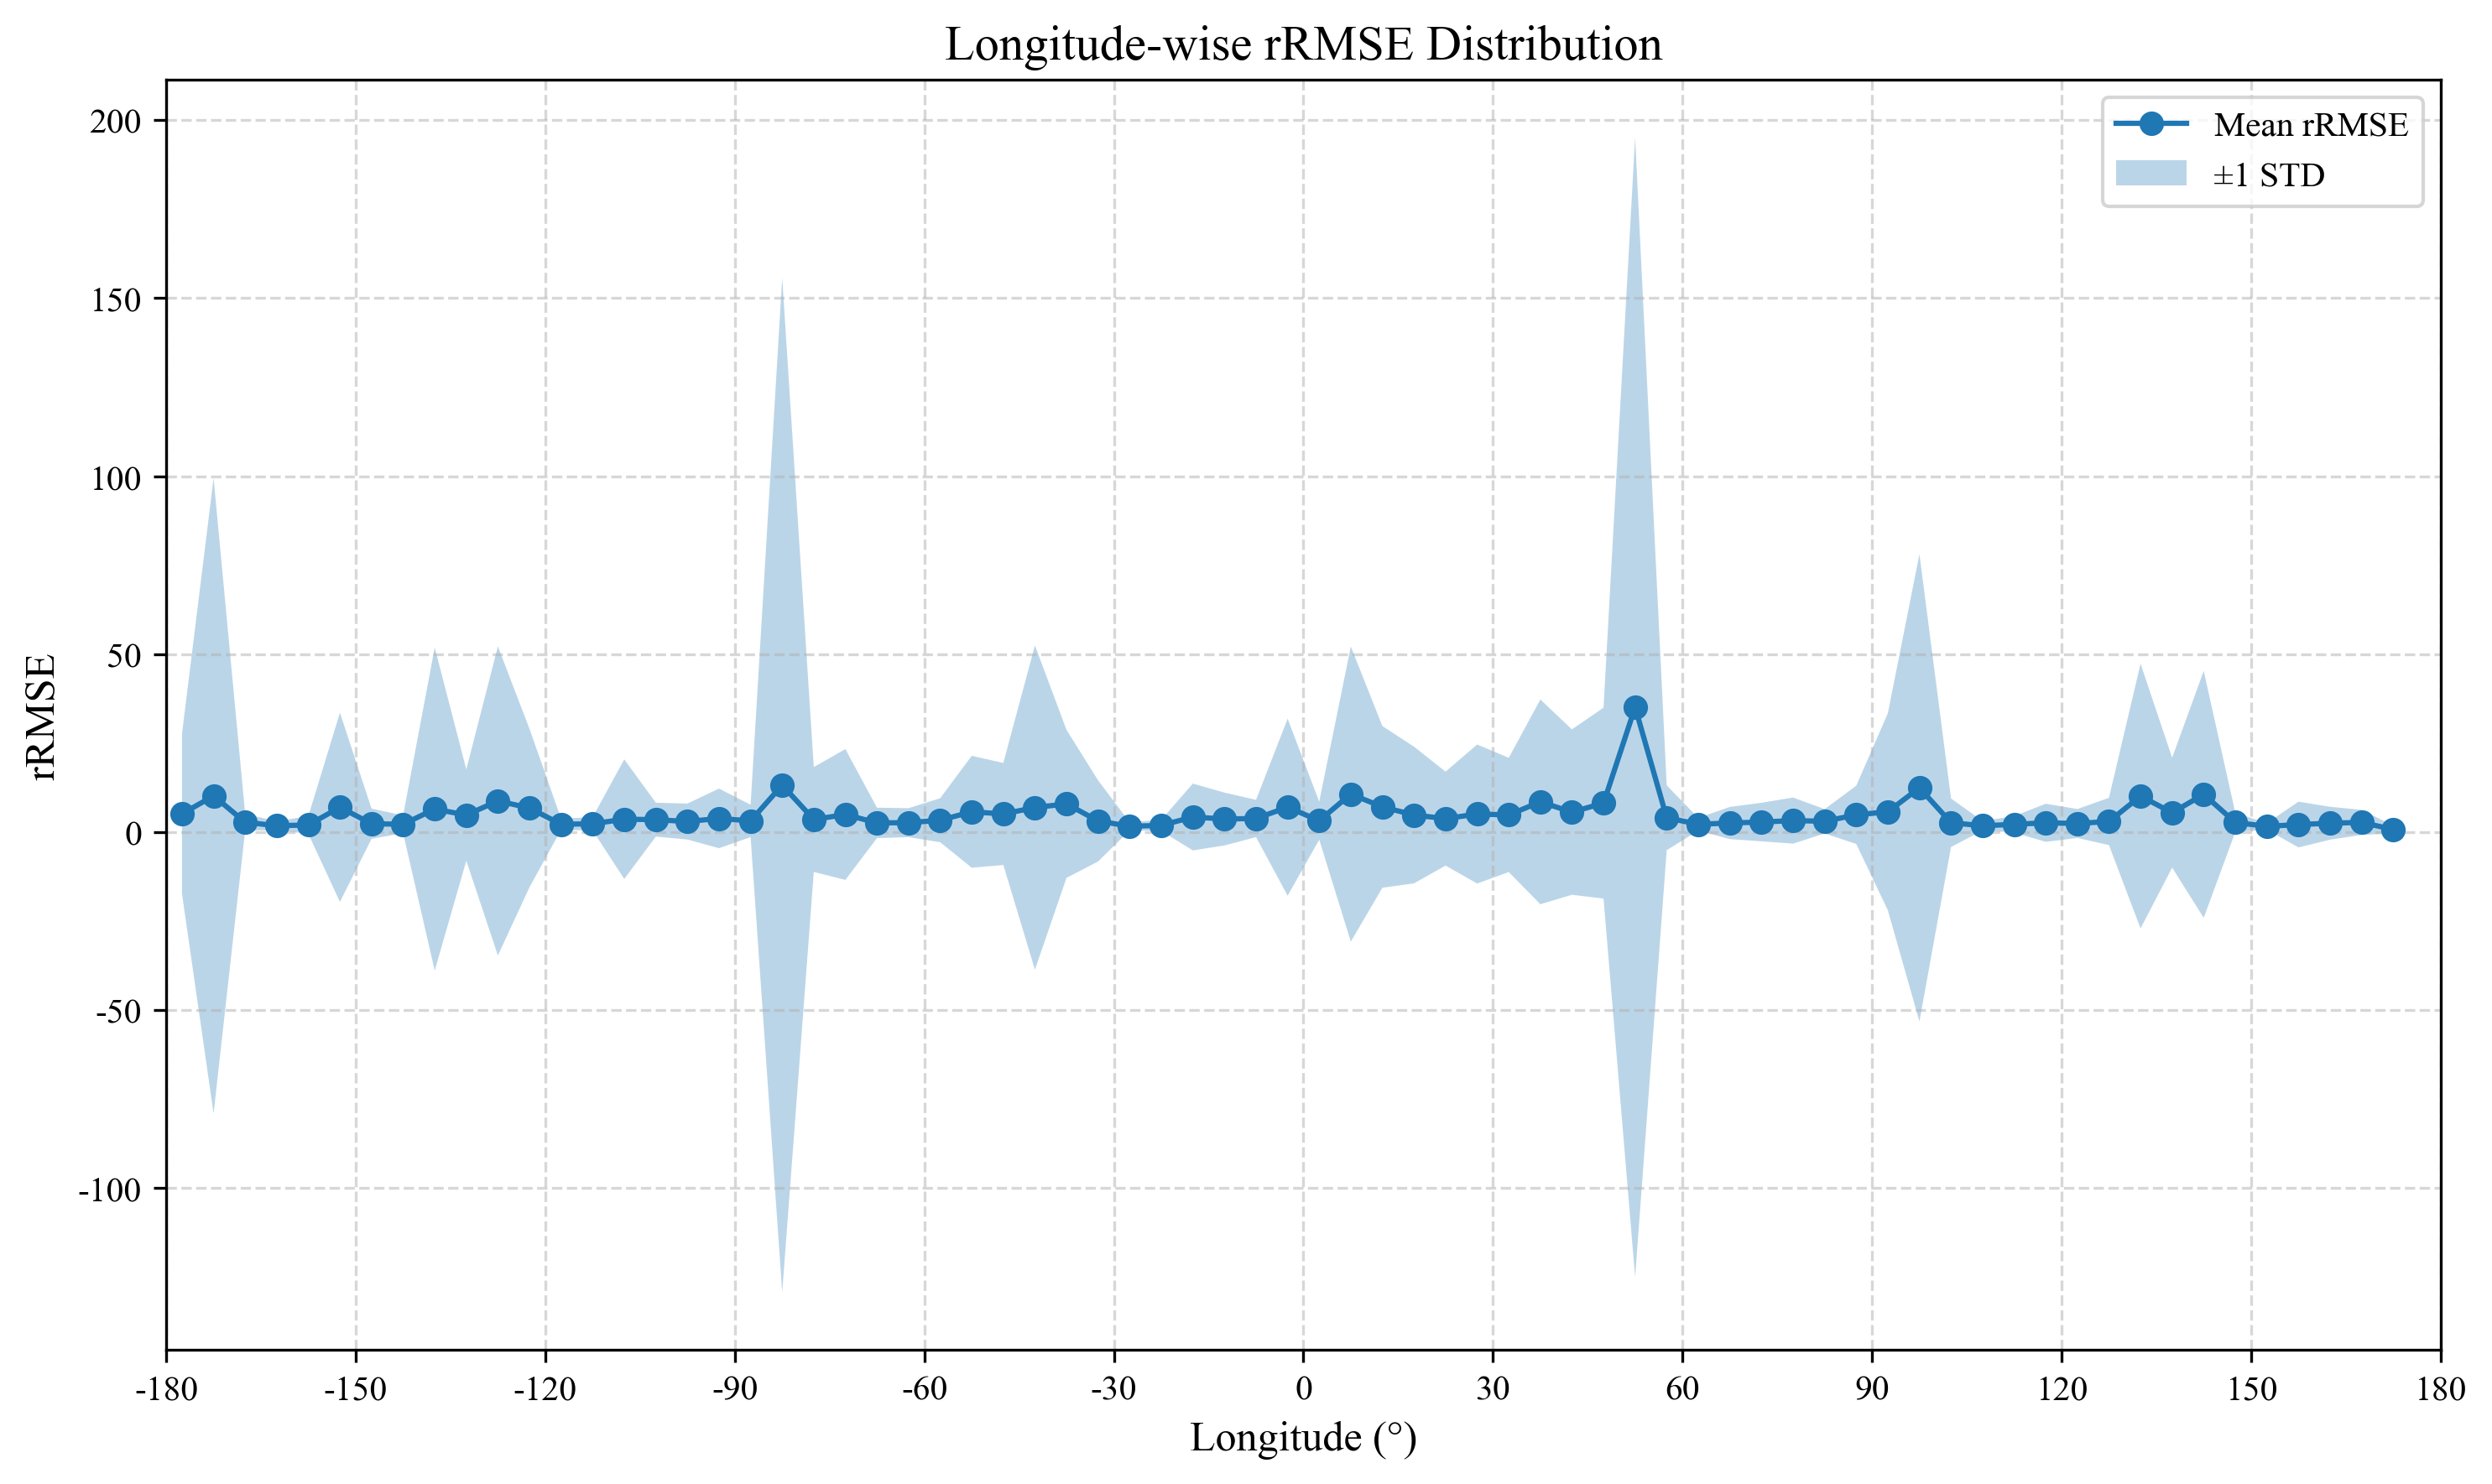

Longitude rRMSE plot saved to /home/nvme/zhaolx/Unet_train/global/regression/rrmse_vs_longitude.png


In [ ]:
# ——— 计算每个格点的 rRMSE map（带除零保护） —————————————————————————————————————————
mean_truth = np.full((R, S), np.nan, dtype=np.float32)
mean_truth[mask] = sum_truth[mask] / count[mask]

# 只有 mean_truth > 0 的格点才计算 rRMSE
valid_rr = mask & (mean_truth > 0)
rrmse_map = np.full((R, S), np.nan, dtype=np.float32)
rrmse_map[valid_rr] = rmse_map[valid_rr] / mean_truth[valid_rr]

# 保存
np.save(out_rrmse_npy, rrmse_map)
print(f"Saved rRMSE map to {out_rrmse_npy}")

# ——— 按纬度 5° 分箱绘制 rRMSE ————————————————————————————————————————————————————
bin_edges_lat   = np.arange(-60,  61, 3)
bin_centers_lat = (bin_edges_lat[:-1] + bin_edges_lat[1:]) / 2
lat_bins        = np.digitize(lat_vec, bin_edges_lat) - 1
n_bins_lat      = len(bin_centers_lat)

means_rr = np.full(n_bins_lat, np.nan, dtype=np.float64)
stds_rr  = np.full(n_bins_lat, np.nan, dtype=np.float64)

for i in range(R):
    b = lat_bins[i]
    if 0 <= b < n_bins_lat:
        row = rrmse_map[i, :]
        # 这里同时过滤 nan、零和非有限值
        vals = row[(~np.isnan(row)) & (row != 0) & np.isfinite(row)]
        if vals.size:
            means_rr[b] = np.nanmean(vals)
            stds_rr[b]  = np.nanstd(vals)

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(bin_centers_lat, means_rr, lw=1.5, marker='o', label='Mean rRMSE')
plt.fill_between(bin_centers_lat,
                 means_rr - stds_rr,
                 means_rr + stds_rr,
                 alpha=0.3, label='±1 STD')
plt.xlabel("Latitude (°)", fontsize=12)
plt.ylabel("rRMSE", fontsize=12)
plt.title("Latitude-wise rRMSE Distribution", fontsize=14)
plt.xlim(-60, 60)
plt.xticks(np.arange(-60, 61, 10))
plt.grid(linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig(out_lat_rr_png, dpi=300)
plt.show()
print(f"Latitude rRMSE plot saved to {out_lat_rr_png}")

# ——— 按经度 5° 分箱绘制 rRMSE ————————————————————————————————————————————————————
bin_edges_lon   = np.arange(-180, 181, 5)
bin_centers_lon = (bin_edges_lon[:-1] + bin_edges_lon[1:]) / 2
lon_bins        = np.digitize(lon_vec, bin_edges_lon) - 1
n_bins_lon      = len(bin_centers_lon)

means_rr_lon = np.full(n_bins_lon, np.nan, dtype=np.float64)
stds_rr_lon  = np.full(n_bins_lon, np.nan, dtype=np.float64)

for j in range(S):
    b = lon_bins[j]
    if 0 <= b < n_bins_lon:
        col = rrmse_map[:, j]
        vals = col[(~np.isnan(col)) & (col != 0) & np.isfinite(col)]
        if vals.size:
            means_rr_lon[b] = np.nanmean(vals)
            stds_rr_lon[b]  = np.nanstd(vals)

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(bin_centers_lon, means_rr_lon, lw=1.5, marker='o', label='Mean rRMSE')
plt.fill_between(bin_centers_lon,
                 means_rr_lon - stds_rr_lon,
                 means_rr_lon + stds_rr_lon,
                 alpha=0.3, label='±1 STD')
plt.xlabel("Longitude (°)", fontsize=12)
plt.ylabel("rRMSE", fontsize=12)
plt.title("Longitude-wise rRMSE Distribution", fontsize=14)
plt.xlim(-180, 180)
plt.xticks(np.arange(-180, 181, 30))
plt.grid(linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig(out_lon_rr_png, dpi=300)
plt.show()
print(f"Longitude rRMSE plot saved to {out_lon_rr_png}")

In [9]:
print(means_rr.shape)
print(means_rr)

(40,)
[ 2.18092799  2.05488634  2.07305503  2.32919097  2.55459046  3.47412848
  5.88004303  6.10305262  4.93288994  4.61682272  4.64351797  5.52931023
  5.48996258  5.7725606   7.54335451  8.49490166  6.41332102  6.41166162
  7.47610855  7.39563179 10.60331249 14.0803299  14.27687931 16.27478218
 13.652174    8.61951637  7.08663321  7.30741549  5.10310364  4.66333961
  3.69770503  3.45867705  3.3250618   3.7216804   3.60592842  3.27894163
  2.7301867   2.7073164   3.025594    3.79138827]
